In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()

In [3]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
## update data
def remove_crl(df):
    max=39
    df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [5]:
# arrange data
# pseudo data males
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_males_clean_pseudotime_v02.parquet')
m_psd = pd.read_parquet(path)
m_psd=m_psd.reset_index()
m_psd=m_psd[['uuid','pseudotime_rank','age']]

#make sure only animals in clean v2 are in the male dataframe:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_males_clean_v2.parquet')
df_males = pd.read_parquet(path)
df_males = remove_crl(df_males)
m_psd = df_males.merge(m_psd, on='uuid', how='left')

#do some cleaning up
m_psd.rename(columns={'pseudotime_rank': 'psd'}, inplace=True)
m_psd.set_index(['psd','uuid','age'], append=True, inplace=True)
m_psd = m_psd.filter(regex=r'\d')

## convert male pseudotime to bins and remap the bins
m_psd['bins'] = pd.qcut(m_psd.index.get_level_values('psd'), len(m_psd.index.get_level_values('age').unique()),labels=False)

ages = m_psd.index.get_level_values('age').unique().to_numpy()
mapdr_males = dict(zip(list(range(len(ages))), ages))
y_temp = m_psd['bins'].to_numpy()
y_temp = [mapdr_males[item] for item in y_temp]

m_psd['remapped_bins'] = y_temp
m_psd.set_index(['bins','remapped_bins'], 
                append=True, inplace=True)

In [6]:
data=m_psd.copy()
pcs = PCA(n_components=2).fit_transform(np.log(data + 1e-6))
ages = data.index.get_level_values('remapped_bins')
pc_df = pd.DataFrame(pcs)
pc_df['age'] = ages

In [7]:
#PC1 correlation
from scipy import stats
[c,p] = stats.spearmanr(pc_df[0], pc_df['age'])

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.


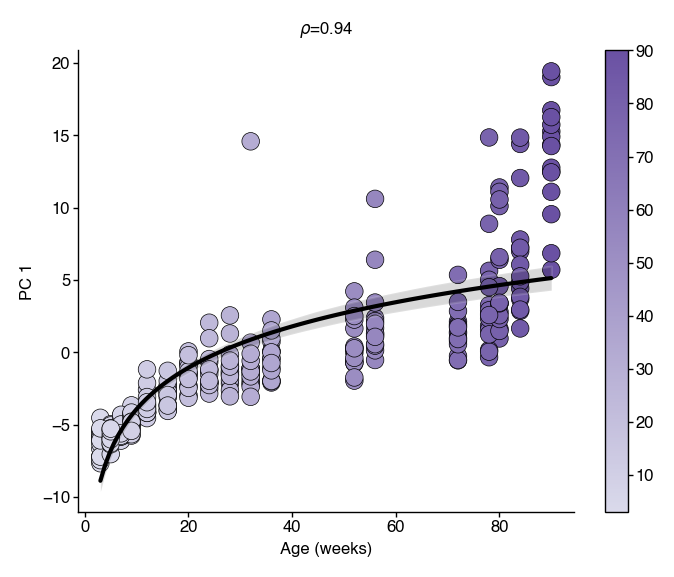

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
plt.scatter(x=pc_df['age'], y=pc_df[0], 
            s=40, 
            c=pc_df['age'], 
            edgecolor='black',
            linewidth=0.25,
            #norm='log',
            cmap=cmm)
ax = sns.regplot(data=pc_df, x='age', y=pc_df[0], scatter=False, color='black', logx=True)
ax.set(xlabel='Age (weeks)', ylabel='PC 1')
plt.title(f'$\\rho$={c:0.2f}')
norm = plt.Normalize(pc_df['age'].min(), pc_df['age'].max())
sns.despine()
sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)
c = PlotConfig()
plt.savefig(c.dana_save_path / "fig2"/ 'H_PCA_psd_correaltion.pdf', bbox_inches='tight')

In [ ]:
# Variance explained by each principal component
variance_explained = pca.explained_variance_ratio_

# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)